In [1]:
from roboflow import Roboflow
rf = Roboflow(api_key="1yy5NqkETqxKpLW9Nyou")
project = rf.workspace("dp-qvshn").project("anomaly-detection-f6l9y")
version = project.version(3)
dataset = version.download("paligemma")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Anomaly-detection-3 in paligemma:: 100%|██████████| 1471/1471 [00:00<00:00, 1736.45it/s]


In [1]:
from PIL import Image
import json

first = json.loads(open(f"Anomaly-detection-3/dataset/_annotations.train.jsonl").readline())
print(first)

image = Image.open(f"Anomaly-detection-3/dataset/{first.get('image')}")
CLASSES = first.get('prefix').replace("detect ", "").split(" ; ")
print(CLASSES)

{'image': 'Robbery007_x264_frame_780_jpg.rf.cc16189478d6e012c29705ffce6b2000.jpg', 'prefix': 'detect gun ; person-holding-gun ; person-lying ; person-running ; person_standing', 'suffix': '<loc0002><loc0416><loc0293><loc0556> person-holding-gun ; <loc0051><loc0443><loc0103><loc0469> gun ; <loc0282><loc0024><loc0994><loc0164> person_standing'}
['gun', 'person-holding-gun', 'person-lying', 'person-running', 'person_standing']


In [2]:
import os

import json

from torch.utils.data import Dataset, DataLoader

from typing import List, Dict, Any, Tuple
from PIL import Image


class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image


test_dataset = DetectionDataset(
    jsonl_file_path=f"Anomaly-detection-3/dataset/_annotations.train.jsonl",
    image_directory_path=f"Anomaly-detection-3/dataset/"
)

val_dataset = DetectionDataset(
    jsonl_file_path=f"Anomaly-detection-3/dataset/_annotations.test.jsonl",
    image_directory_path=f"Anomaly-detection-3/dataset/"
)


In [12]:
import torch
import numpy as np
import supervision as sv
from transformers import AutoProcessor as PaliProcessor, PaliGemmaForConditionalGeneration
import re

# Inicializácia modelu a procesora Paligemma
paligemma_model = PaliGemmaForConditionalGeneration.from_pretrained(
    "paligemma", torch_dtype=torch.bfloat16, device_map="cuda:0", revision="bfloat16"
).eval()
paligemma_processor = PaliProcessor.from_pretrained("paligemma")


# Funkcia pre generovanie predikcií pomocou modelu Paligemma
def run_paligemma_timeline(image, prompt="detect"):
    prompt_with_image_token = "<image> " + prompt
    model_inputs = paligemma_processor(text=prompt_with_image_token, images=image, return_tensors="pt").to("cuda")
    input_len = model_inputs["input_ids"].shape[-1]
    generation = paligemma_model.generate(**model_inputs, max_new_tokens=100, do_sample=False, num_beams=3)
    decoded = paligemma_processor.decode(generation[0][input_len:], skip_special_tokens=False)
    print(decoded)
    return decoded

# Definovanie dát pre vyhodnotenie
targets = []
predictions = []

# for i in range(len(val_dataset)):  # Nahraďte val_dataset vašim datasetom
# # Definovanie dát pre vyhodnotenie
# targets = []
# predictions = []


for item in val_dataset:  # Iterujeme cez dataset
    prompt = item[0]  # Prvý element je prefix (prompt)
    suffix = item[1]  # Druhý element je suffix
    image = item[2]   # Tretí element je samotný obrázok
    w, h = image.size  # Získame rozmery obrázka

    # Získanie generovaných predikcií
    generated_text = run_paligemma_timeline(image, prompt)

    # Generovanie predikcií ako detekcie
    prediction = sv.Detections.from_lmm(lmm="paligemma", result=generated_text, resolution_wh=(w, h), classes=CLASSES)
    prediction.confidence = np.ones(len(prediction))  # Alebo použite dôveryhodnosti, ak sú k dispozícii

    # Príprava cieľových údajov
    target = sv.Detections.from_lmm(lmm="paligemma", result=suffix, resolution_wh=(w, h), classes=CLASSES)

    # Pridanie predikcií a cieľov do zoznamu
    targets.append(target)
    predictions.append(prediction)

# Vyhodnotenie mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(predictions=predictions, targets=targets)

# Výpis výsledkov
print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")



Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.30s/it]


<loc0321><loc0502><loc0789><loc0626> person_standing ; <loc0204><loc0765><loc0520><loc0867> person_running ; <loc0652><loc0169><loc0993><loc0387> person-holding-gun ; <loc0192><loc0633><loc0520><loc0719> person-lying<eos>
<loc0192><loc0702><loc0463><loc0819> person_standing ; <loc0177><loc0571><loc0409><loc0630> person_running ; <loc0453><loc0399><loc0999><loc0608> person-holding-gun ; <loc0731><loc0702><loc0993><loc0905> person-lying<eos>
<loc0411><loc0364><loc0789><loc0493> person_standing ; <loc0411><loc0362><loc0789><loc0493> person-running ; <loc0549><loc0366><loc0613><loc0398> gun ; <loc0549><loc0366><loc0617><loc0398> person-holding-gun ; <loc0389><loc0342><loc0786><loc0495> person-lying<eos>
<loc0270><loc0146><loc0727><loc0243> person_standing ; <loc0273><loc0129><loc0727><loc0236> person_running ; <loc0282><loc0303><loc0477><loc0359> person-holding-gun<eos>
<loc0320><loc0560><loc0720><loc0762> person_standing ; <loc0163><loc0574><loc0321><loc0637> person_running ; <loc0163><lo

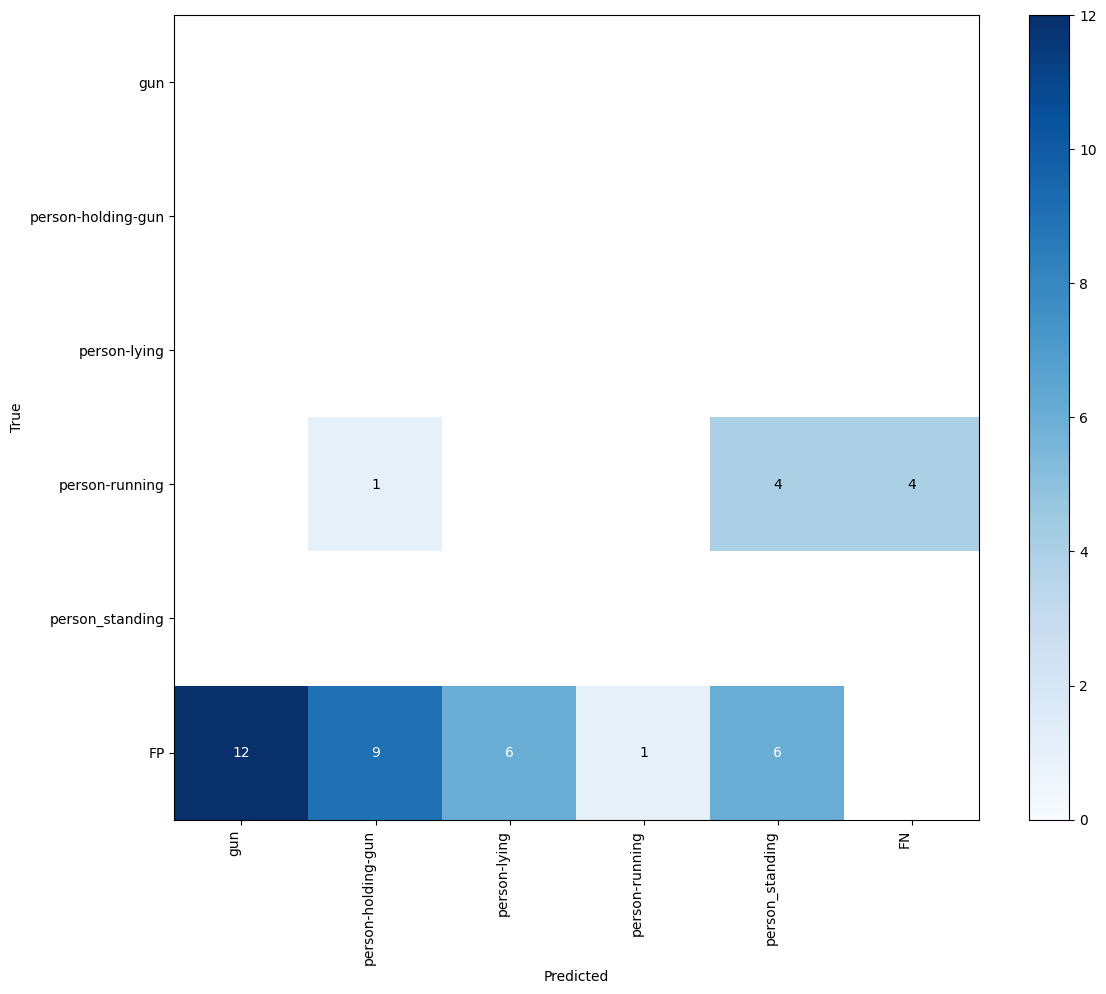

In [13]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

# Plot confusion matrix
_ = confusion_matrix.plot()


In [23]:
import torch
torch.cuda.empty_cache()  
torch.cuda.ipc_collect()


In [4]:
import torch
import numpy as np
import supervision as sv
from transformers import AutoProcessor as PaliProcessor, PaliGemmaForConditionalGeneration
import re

paligemmaFT_model = PaliGemmaForConditionalGeneration.from_pretrained(
    "paligemma", torch_dtype=torch.bfloat16, device_map="cuda:0", revision="bfloat16"
).eval()
paligemmaFT_processor = PaliProcessor.from_pretrained("paligemma")
MODEL_PATH = "paligemma-weights.pth"  # Tvoj súbor
# paligemmaFT_model.load_state_dict(torch.load("paligemma-weights.pth"), strict=False , weights_only=True)
state_dict = torch.load("paligemma-weights.pth", map_location="cuda", weights_only=True)
paligemmaFT_model.load_state_dict(state_dict, strict=False)


# #paligemma ft setup
# #paligemma ft setup
# Funkcia pre generovanie predikcií pomocou modelu Paligemma
def run_paligemma_timeline(image, prompt="detect"):
    prompt_with_image_token = "<image> " + prompt
    model_inputs = paligemmaFT_processor(text=prompt_with_image_token, images=image, return_tensors="pt").to("cuda")
    input_len = model_inputs["input_ids"].shape[-1]
    generation = paligemmaFT_model.generate(**model_inputs, max_new_tokens=100, do_sample=False, num_beams=3)
    decoded = paligemmaFT_processor.decode(generation[0][input_len:], skip_special_tokens=False)
    decoded = decoded.replace("<eos>", "").strip()
    print(decoded)
    return decoded

# Definovanie dát pre vyhodnotenie
targets = []
predictions = []

# for i in range(len(val_dataset)):  # Nahraďte val_dataset vašim datasetom
# # Definovanie dát pre vyhodnotenie
# targets = []
# predictions = []


for item in val_dataset:  # Iterujeme cez dataset
    prompt = item[0]  # Prvý element je prefix (prompt)
    suffix = item[1]  # Druhý element je suffix
    image = item[2]   # Tretí element je samotný obrázok
    w, h = image.size  # Získame rozmery obrázka

    # Získanie generovaných predikcií
    generated_text = run_paligemma_timeline(image, prompt)
    
    # Generovanie predikcií ako detekcie
    prediction = sv.Detections.from_lmm(lmm="paligemma", result=generated_text, resolution_wh=(w, h), classes=CLASSES)
    prediction.confidence = np.ones(len(prediction))  # Alebo použite dôveryhodnosti, ak sú k dispozícii

    # Príprava cieľových údajov
    target = sv.Detections.from_lmm(lmm="paligemma", result=suffix, resolution_wh=(w, h), classes=CLASSES)

    # Pridanie predikcií a cieľov do zoznamu
    targets.append(target)
    predictions.append(prediction)

# # Vyhodnotenie mAP
# mean_average_precision = sv.MeanAveragePrecision.from_detections(predictions=predictions, targets=targets)
# 
# # Výpis výsledkov
# print(f"map50_95: {mean_average_precision.map50_95:.2f}")
# print(f"map50: {mean_average_precision.map50:.2f}")
# print(f"map75: {mean_average_precision.map75:.2f}")


Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.68s/it]


<loc0269><loc0534><loc0786><loc0835> person_standing ; <loc0384><loc0779><loc0782><loc1023> person-running ; <loc0497><loc0482><loc0651><loc0633> person-holding-gun ; <loc0457><loc0000><loc0892><loc0228> person-lying
<loc0310><loc0696><loc0685><loc0823> person_standing ; <loc0478><loc0410><loc0635><loc0669> person-lying ; <loc0478><loc0410><loc0630><loc0666> person-running ; <loc0418><loc0713><loc0479><loc0767> gun ; <loc0418><loc0713><loc0478><loc0767> person-holding-gun
<loc0122><loc0711><loc0259><loc0753> person_running ; <loc0360><loc0633><loc0504><loc0836> person-lying ; <loc0129><loc0488><loc0303><loc0557> person_standing ; <loc0235><loc0545><loc0274><loc0598> gun ; <loc0129><loc0706><loc0240><loc0742> person-holding-gun
<loc0000><loc0795><loc0632><loc0913> person_standing ; <loc0000><loc0495><loc0138><loc0585> person_running ; <loc0000><loc0100><loc1023><loc0909> person-holding-gun ; <loc0000><loc0101><loc1023><loc0735> person-lying ; <loc0000><loc0288><loc0138><loc0412> gun
<lo

In [ ]:
del paligemmaFT_model
torch.cuda.empty_cache()

In [5]:
# Vyhodnotenie mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(predictions=predictions, targets=targets)

# Výpis výsledkov
print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.06
map50: 0.12
map75: 0.05


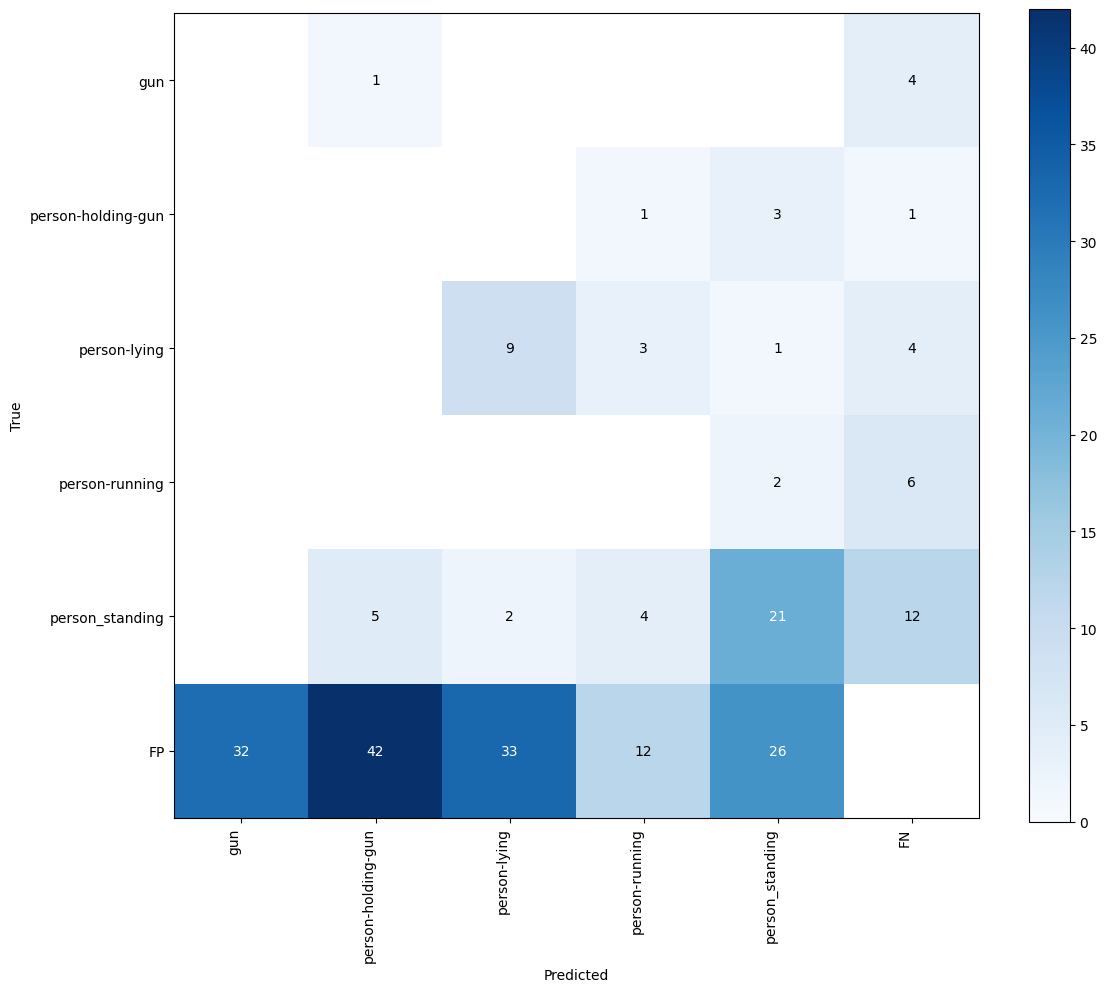

In [6]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

# Plot confusion matrix
_ = confusion_matrix.plot()
